# Predictive modeling of airline customer bookings: EDA
## Dr José M Albornoz
### February 2024

In this notebook we will perform an exploratory data analysis of a dataset describing bookings made airline customers. We are interested in predicting if a booking will be completed.

# 0.- Imports & utility functions

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)

# maximum number of dataframe rows and columns displayed
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

RANDOM_STATE = 801
pd.options.mode.chained_assignment = None

target_labels = ['Completed', 'Not_completed']

In [2]:
def compareCategoricalFeatures(df1, df2, feature, target_labels):
    
    '''
    This function takes two dataframes, each corresponding to one possible outcome of a binary target, and
    returns another dataframe containing a table of normalised frequencies for each value of a categorical 
    feature, for each target outcome.
    
    Parameters:
     * df1: dataframe for the positive outcome
     * df2: dataframe for the negative outcome
     * feature: categorical feature for which frequencies are going to be calculated
     * labels: labels that describe each of the target outcomes
     
    Returns:
     * dfB: dataframe containing normalised frequencies for the specified categorical feature. The columns
            of this dataframe are:
                 - Outcome: target outcomes, as specified by 'labels'
                 - No: normalised frequency of negative values for the specified feature for each target outcome
                 - Yes: normalised frequency of positive values for the specified feature for each target outcome
     * feature_labels: labels for the values of the categorial feature, sorted by frequency            
    '''
    
    dfA = pd.DataFrame({labels[0]: df1[feature].value_counts().sort_index(),
                        labels[1]: df2[feature].value_counts().sort_index()})
    
    dfB =dfA.T.reset_index()
    
    feature_labels = dfB.columns.to_list()[1:] 
    dfB.columns = ['Outcome'] + feature_labels 
    
    # normalise counts for each outcome
    dfB.iloc[0,1:] = dfB.iloc[0,1:]/dfB.iloc[0,1:].sum()
    dfB.iloc[1,1:] = dfB.iloc[1,1:]/dfB.iloc[1,1:].sum()
    
    return dfB, feature_labels  

# 1.- Read data

In [3]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [5]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


## 2.1.- Data dictionary

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

## 2.2.- Unique values per feature

In [6]:
df.nunique()

num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            470
length_of_stay           335
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64

## 2.3.- Missing values

In [7]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

# 3.- Exploratory data analysis: Part A

We will begin by performing a necessary transformation:

In [8]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [9]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [10]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

Let's split the dataset into the target and the features we will use for prediction:

In [11]:
target_name = "booking_complete"
data0, target = df.drop(columns=target_name), df[target_name]

## 3.1.- Target analysis

Let's examine the distribution of values for the prediction target

In [12]:
target.value_counts()*100/data0.shape[0]

0    85.044
1    14.956
Name: booking_complete, dtype: float64

Text(0.5, 1.0, 'Percentage of completed bookings')

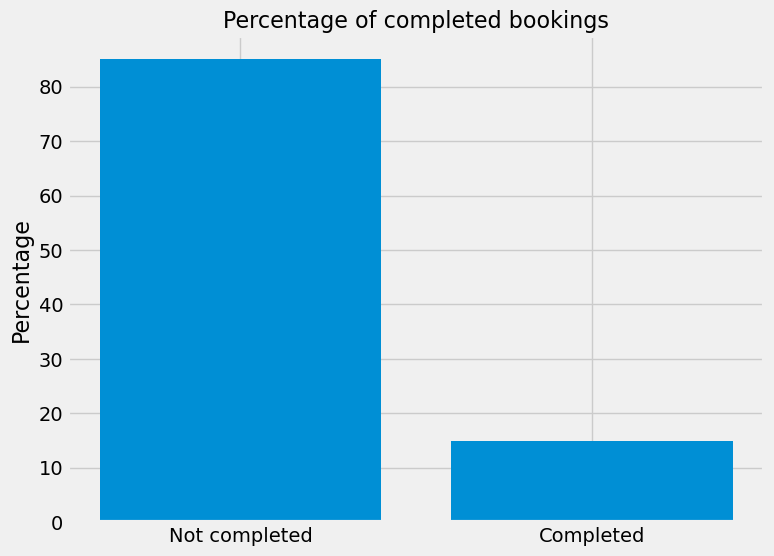

In [13]:
plt.bar(['Not completed', 'Completed'], target.value_counts()*100/data0.shape[0])
plt.ylabel('Percentage', fontsize=16)
plt.title('Percentage of completed bookings', fontsize=16)

We are dealing with an imbalanced target: some 15% of the cases correspond to the positive class we want to predict.

## 3.2.- Univariate feature analysis

We will examine in detail the features that will be used to train a predictive model. Let's split these features into numerical and categorical: 

In [14]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data0)
categorical_columns = categorical_columns_selector(data0)

### 3.2.1.- Numerical features

In [15]:
numerical_columns

['num_passengers',
 'purchase_lead',
 'length_of_stay',
 'flight_hour',
 'flight_day',
 'wants_extra_baggage',
 'wants_preferred_seat',
 'wants_in_flight_meals',
 'flight_duration']

<font size="4">**NUMBER OF PASSENGERS**:</font>

Text(0.5, 1.0, ' Distribution of number of passengers')

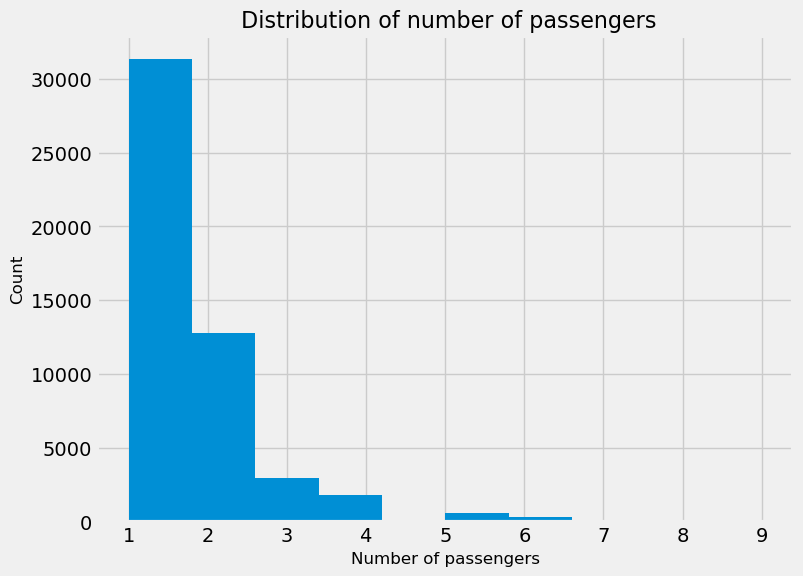

In [16]:
data0['num_passengers'].hist()
plt.xlabel('Number of passengers', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(' Distribution of number of passengers', fontsize=16)

By far most of the bookings involve at most 2 passengers.

<font size="4">**PURCHASE LEAD**:</font>

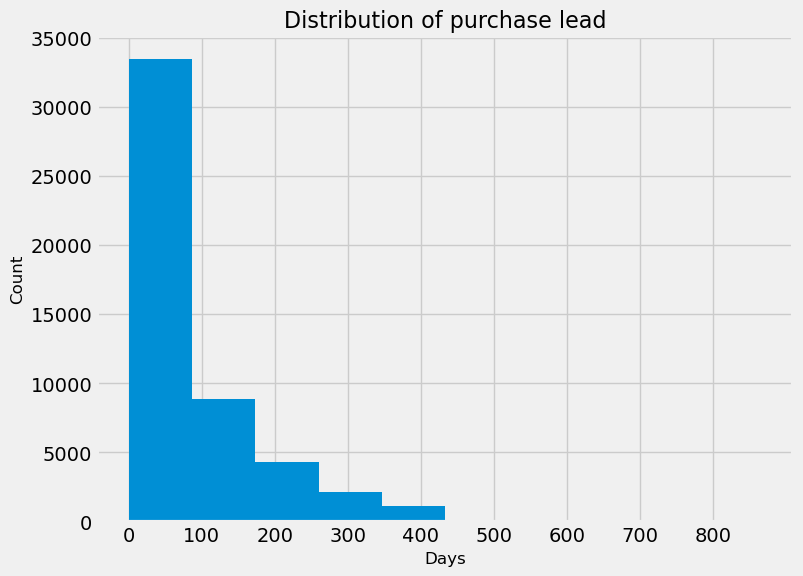

In [17]:
data0['purchase_lead'].hist()
plt.xlabel('Days', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of purchase lead', fontsize=16)
plt.xticks(np.arange(0, 900, 100.0));

We observe that most of the bookings involve a lead of less that 200 days.

<font size="4">**LENGTH OF STAY**:</font>

(0.0, 200.0)

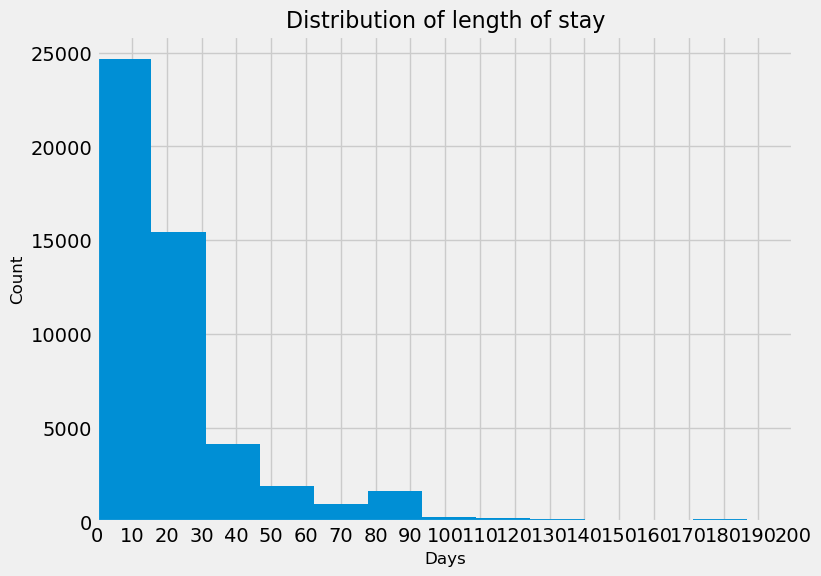

In [18]:
data0['length_of_stay'].hist(bins=50)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of length of stay', fontsize=16)
plt.xticks(np.arange(0, 400, 10.0));
plt.xlim(0, 200)

Most of the cases in the dataset represent bookings with stays of less than 30 days.

<font size="4">**FLIGHT HOUR**:</font>

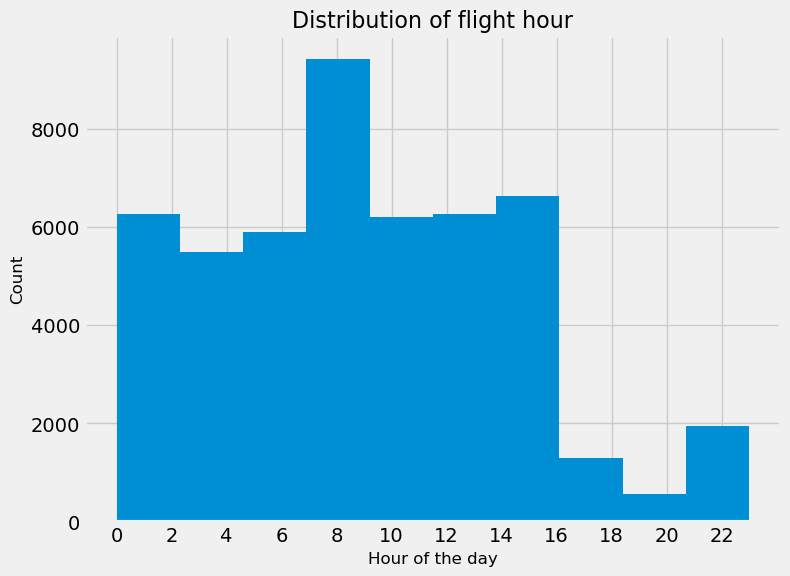

In [19]:
data0['flight_hour'].hist()
plt.xlabel('Hour of the day', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of flight hour', fontsize=16)
plt.xticks(np.arange(0, 23, 2.0));

A high number of fligths were booked for a window between 7 and 9 AM. The number of booked flights drops dramatically after 4 PM.

<font size="4">**FLIGHT DAY**:</font>

Text(0.5, 1.0, 'Distribution of flight day')

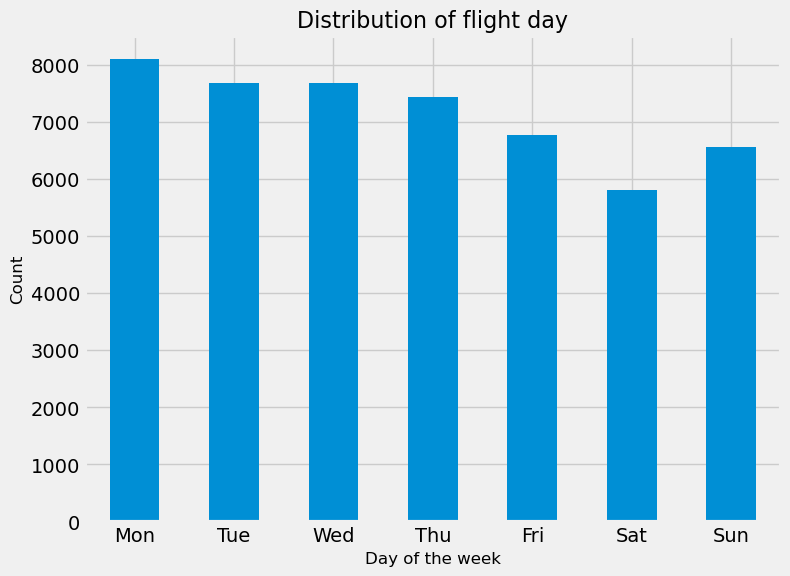

In [20]:
ax = data0['flight_day'].value_counts().sort_index().plot.bar()
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Count', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of flight day', fontsize=16)

Less flights are booked on Friday and the weekend than on the rest of the week.

<font size="4">**EXTRA BAGGAGE**:</font>

Text(0.5, 1.0, 'Distribution of requests for extra baggage')

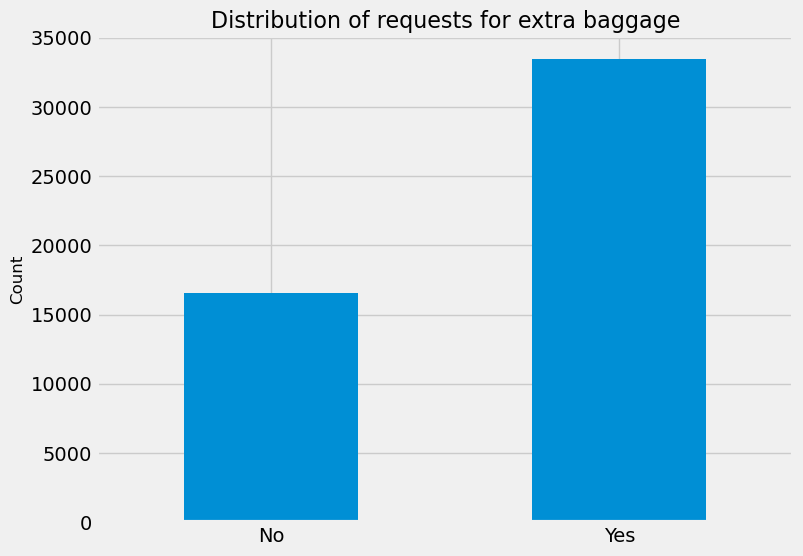

In [21]:
ax = data0['wants_extra_baggage'].value_counts().sort_index().plot.bar()
labels = ['No', 'Yes']
plt.ylabel('Count', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of requests for extra baggage', fontsize=16)

<font size="4">**PREFERRED SEAT**:</font>

Text(0.5, 1.0, 'Distribution of requests for preferred seat')

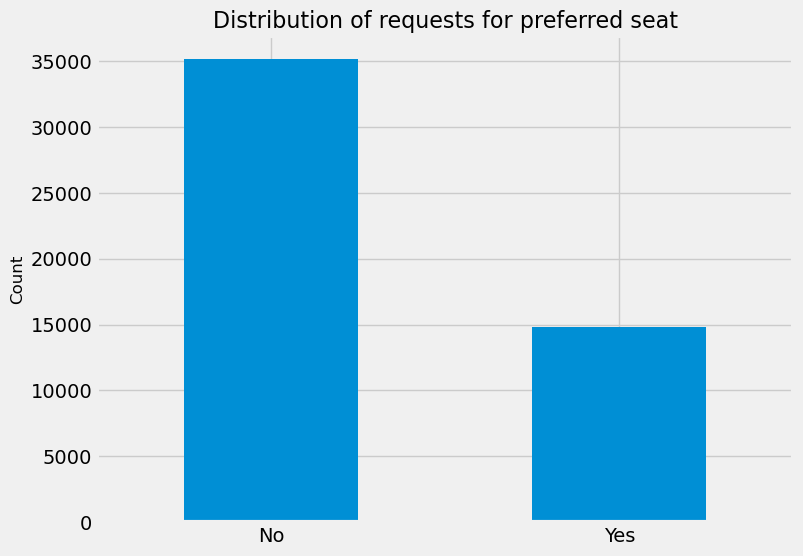

In [22]:
ax = data0['wants_preferred_seat'].value_counts().sort_index().plot.bar()
labels = ['No', 'Yes']
plt.ylabel('Count', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of requests for preferred seat', fontsize=16)

From the last two plots we learn that most customers do not request a preferred seat, but request an extra baggage allowance.

<font size="4">**IN-FLIGHT MEALS**:</font>

Text(0.5, 1.0, 'Distribution of requests for in-flight meals')

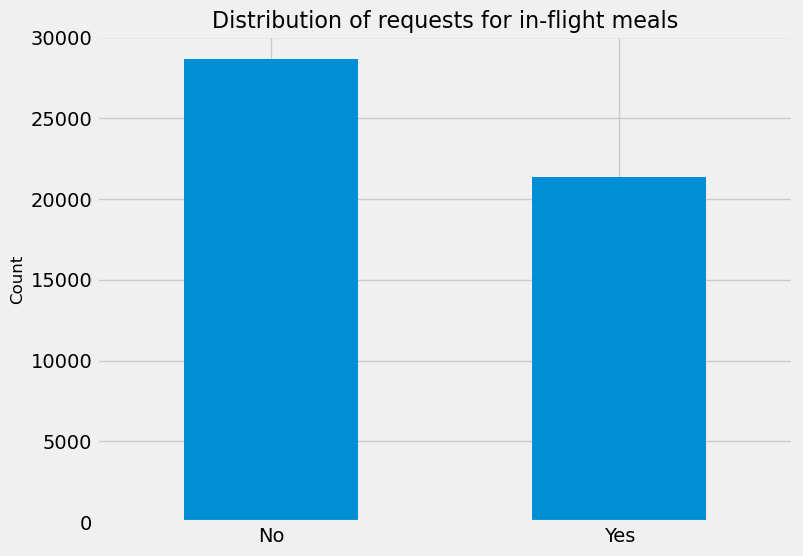

In [23]:
ax = data0['wants_in_flight_meals'].value_counts().sort_index().plot.bar()
labels = ['No', 'Yes']
plt.ylabel('Count', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of requests for in-flight meals', fontsize=16)

Most passengers do not request in-flight meals, albeit for a small margin.

<font size="4">**FLIGHT DURATION**:</font>

Text(0.5, 1.0, 'Distribution of flight duration')

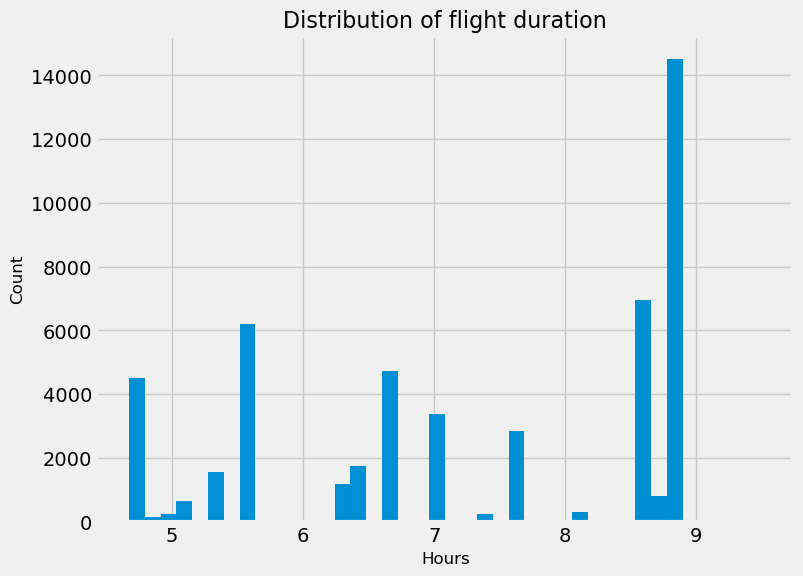

In [24]:
data0['flight_duration'].hist(bins=40)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of flight duration', fontsize=16)

Most booked flights last between 8 1/2 and 9 hours.

### 3.2.2.- Categorical features

In [25]:
categorical_columns

['sales_channel', 'trip_type', 'route', 'booking_origin']

<font size="4">**SALES CHANNEL**:</font>

Text(0.5, 1.0, 'Distribution of sales channel')

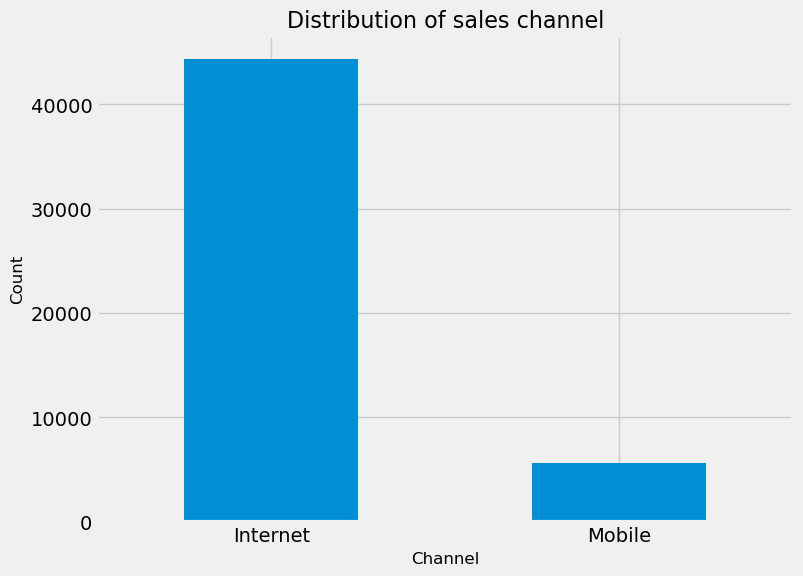

In [26]:
ax = data0['sales_channel'].value_counts().sort_index().plot.bar()
labels = ['Internet', 'Mobile']
plt.xlabel('Channel', fontsize=12)
plt.ylabel('Count', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of sales channel', fontsize=16)

Most of the bookings are done over the Internet rather than on a obile device.

<font size="4">**TRIP TYPE**:</font>

In [27]:
data0['trip_type'].value_counts().sort_index()

CircleTrip      116
OneWay          387
RoundTrip     49497
Name: trip_type, dtype: int64

Text(0.5, 1.0, 'Distribution of trip types')

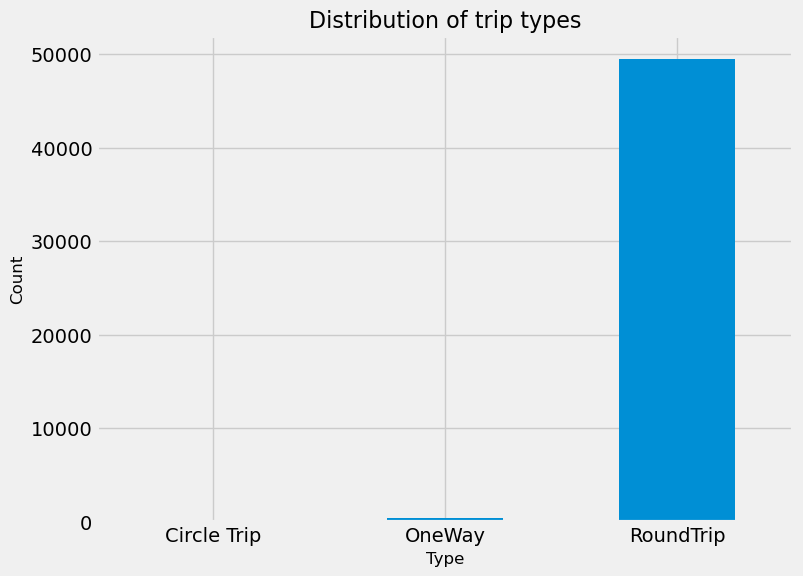

In [28]:
ax = data0['trip_type'].value_counts().sort_index().plot.bar()
labels = ['Circle Trip', 'OneWay', 'RoundTrip']
plt.xlabel('Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of trip types', fontsize=16)

Most of the booked flights are round trip flights.

<font size="4">**ROUTE**:</font>

[]

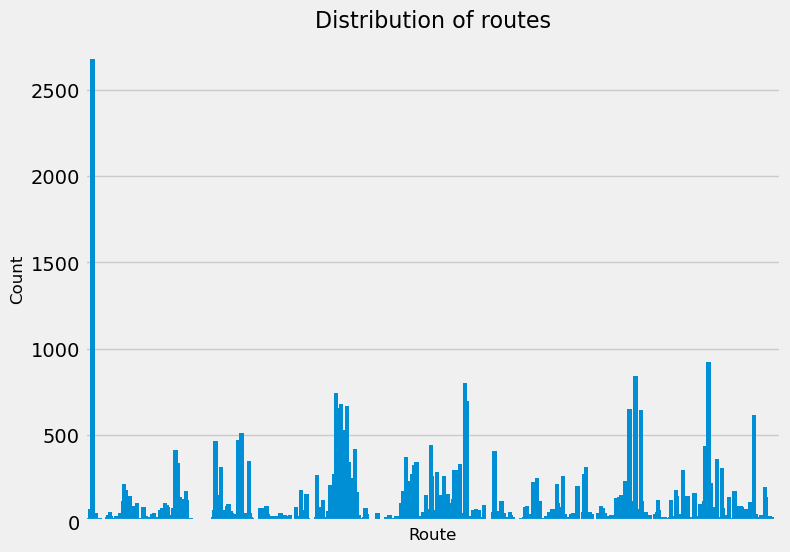

In [29]:
ax = data0['route'].value_counts().sort_index().plot.bar(width=5)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of routes', fontsize=16)
ax.set_xticks([])

In [30]:
data0['route'].value_counts().sort_index().idxmax()

'AKLKUL'

As seen above, there are some routes that are extremely popular, such as Auckland - Kuala Lumpur

<font size="4">**BOOKING ORIGIN**:</font>

[]

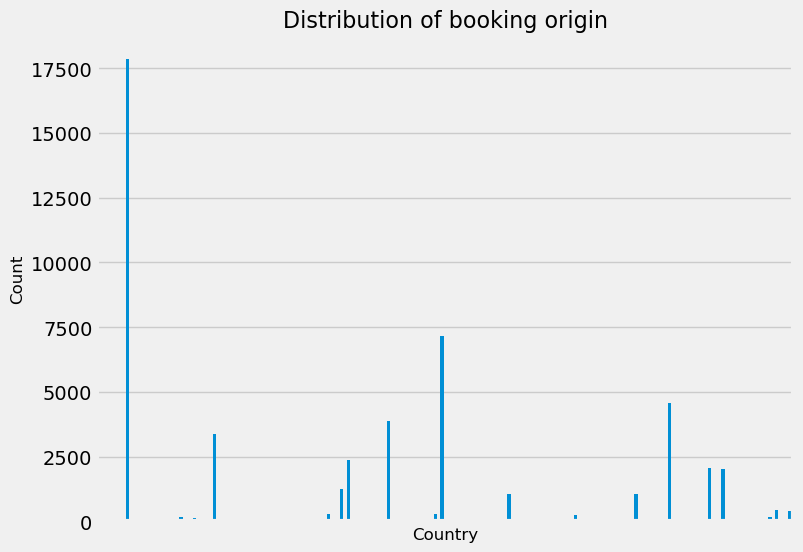

In [31]:
ax = data0['booking_origin'].value_counts().sort_index().plot.bar()
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of booking origin', fontsize=16)
ax.set_xticks([])

In [32]:
data0['booking_origin'].value_counts().sort_index().idxmax()

'Australia'

Just as in the case of routes, some countries have a very high frequency when it comes to bookings.

## 3.3.- Bivariate feature analysis

In this stage of the analysis we will contrast the values of the features for the two outcomes that we want to predict. This will allow us to identify features that contain predictive power. 

For exploratory data analysis purposes, we will divide the original dataset into two subsets: one that corresponds to completed bookings, and another that corresponds to bookings that were not completed.

In [33]:
target_name

'booking_complete'

In [34]:
df_completed = df[df[target_name] == 1]
df_not_completed = df[df[target_name] == 0]

### 3.3.1.- Numerical features

<font size="4">**NUMBER OF PASSENGERS**:</font>

[Text(1, 0, 'Completed'), Text(2, 0, 'Not completed')]

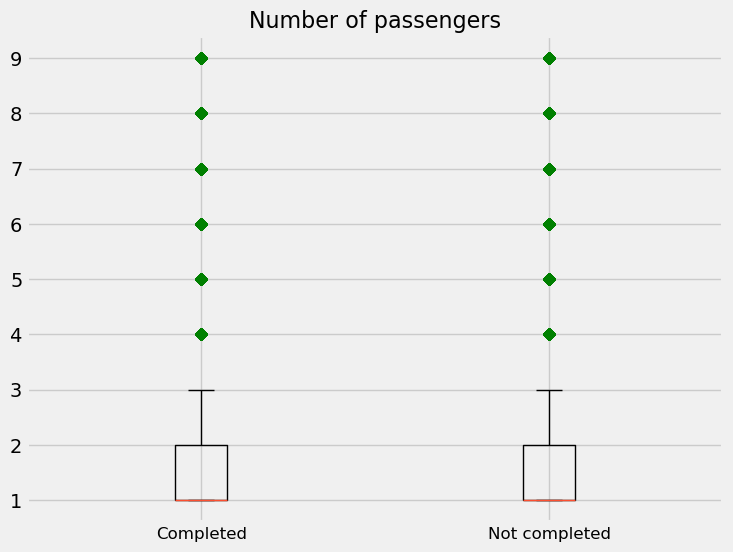

In [35]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([df_completed['num_passengers'], df_not_completed['num_passengers']], 0, 'gD')

plt.title('Number of passengers', fontsize=16)

labels = ['Completed', 'Not completed']
ax.set_xticklabels(labels, fontsize=12)

The number of passengers does not seem to make a difference in booking completion.

<font size="4">**PURCHASE LEAD**:</font>

[Text(1, 0, 'Completed'), Text(2, 0, 'Not completed')]

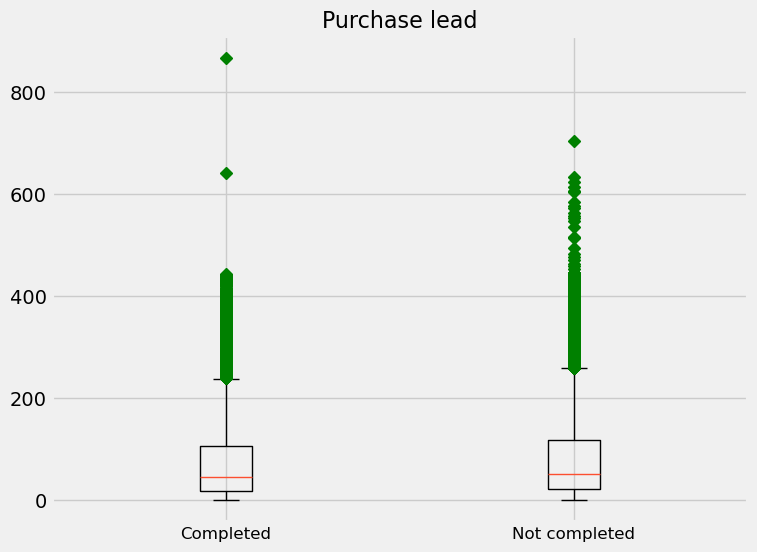

In [36]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([df_completed['purchase_lead'], df_not_completed['purchase_lead']], 0, 'gD')

plt.title('Purchase lead', fontsize=16)

labels = ['Completed', 'Not completed']
ax.set_xticklabels(labels, fontsize=12)

Text(0.5, 1.0, 'Purchase lead')

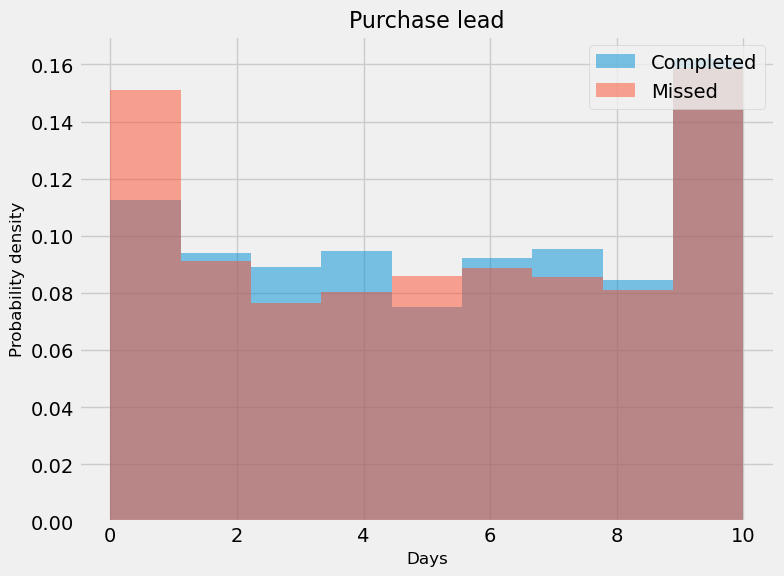

In [37]:
bins = np.linspace(0, 10, 10)

plt.hist(df_completed['purchase_lead'], bins, alpha=0.5, density=True, label='Completed')
plt.hist(df_not_completed['purchase_lead'], bins, alpha=0.5, density=True, label='Missed')
plt.legend(loc='upper right')
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Days', fontsize=12)
plt.title('Purchase lead', fontsize=16)

There is a slight difference in purchase lead between the two outcomes we want to predict.

<font size="4">**LENGTH OF STAY**:</font>

[Text(1, 0, 'Completed'), Text(2, 0, 'Not completed')]

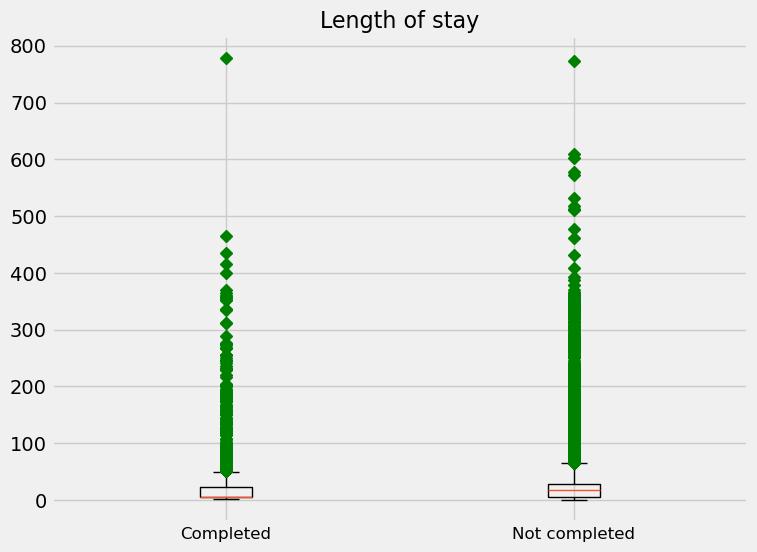

In [38]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([df_completed['length_of_stay'], df_not_completed['length_of_stay']], 0, 'gD')

plt.title('Length of stay', fontsize=16)

labels = ['Completed', 'Not completed']
ax.set_xticklabels(labels, fontsize=12)

Text(0.5, 1.0, 'Length of stay')

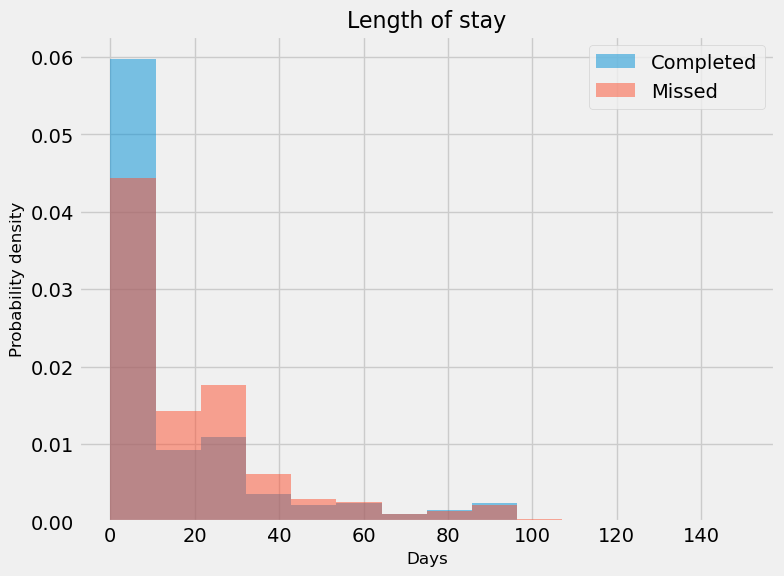

In [39]:
bins = np.linspace(0, 150, 15)

plt.hist(df_completed['length_of_stay'], bins, alpha=0.5, density=True, label='Completed')
plt.hist(df_not_completed['length_of_stay'], bins, alpha=0.5, density=True, label='Missed')
plt.legend(loc='upper right')
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Days', fontsize=12)
plt.title('Length of stay', fontsize=16)

There is a slight difference in length of stay between the two outcomes we want to predict.

<font size="4">**FLIGHT HOUR**:</font>

[Text(1, 0, 'Completed'), Text(2, 0, 'Not completed')]

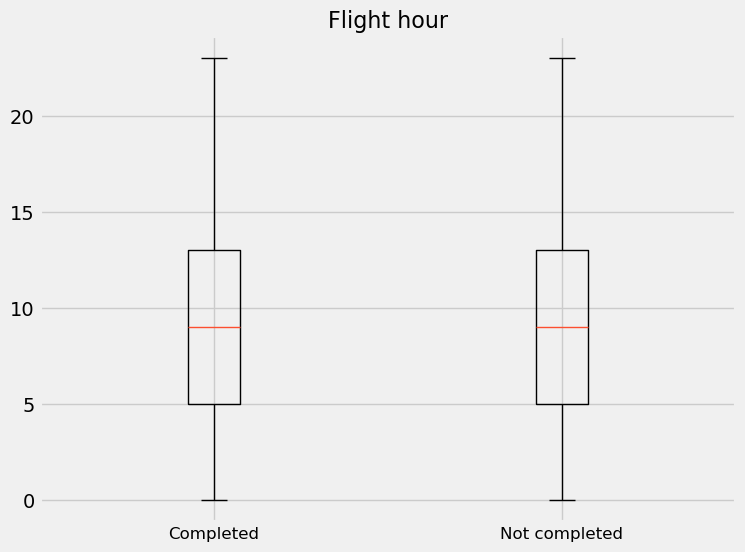

In [40]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([df_completed['flight_hour'], df_not_completed['flight_hour']], 0, 'gD')

plt.title('Flight hour', fontsize=16)

labels = ['Completed', 'Not completed']
ax.set_xticklabels(labels, fontsize=12)

Flight hour does not seem to make a difference in booking completion.

<font size="4">**FLIGHT DAY**:</font>

[Text(1, 0, 'Completed'), Text(2, 0, 'Not completed')]

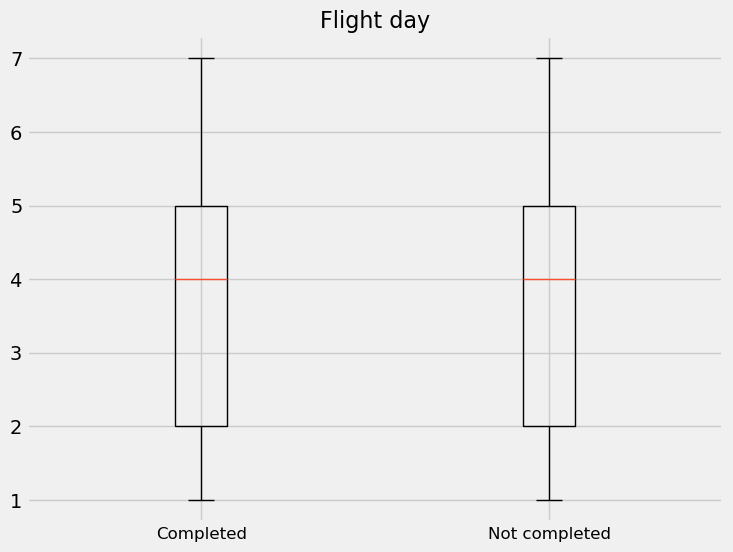

In [41]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([df_completed['flight_day'], df_not_completed['flight_day']], 0, 'gD')

plt.title('Flight day', fontsize=16)

labels = ['Completed', 'Not completed']
ax.set_xticklabels(labels, fontsize=12)

Flight day does not seem to make a difference in booking completion.

<font size="4">**EXTRA BAGGAGE**:</font>

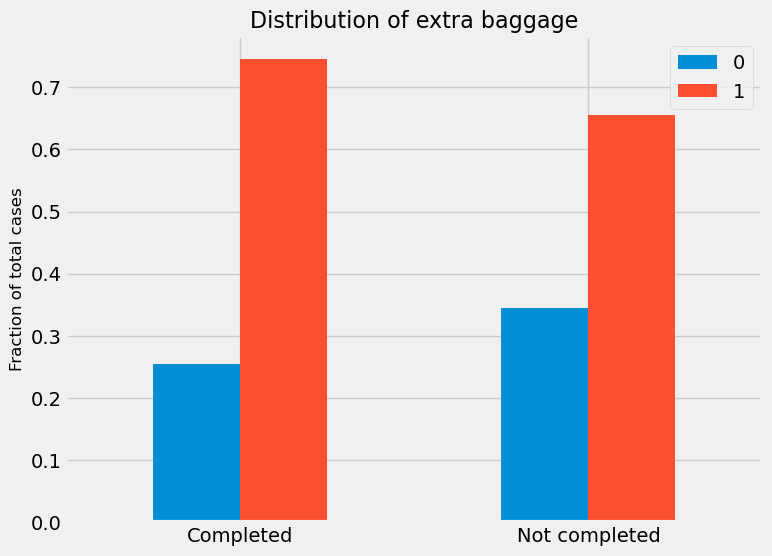

In [42]:
dfp, feature_labels = compareCategoricalFeatures(df_completed, df_not_completed, 'wants_extra_baggage', target_labels)

ax = dfp.plot(x="Outcome", y=feature_labels, kind="bar") 

plt.ylabel('Fraction of total cases', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of extra baggage', fontsize=16)
plt.xlabel('');

There seems to be a small difference when requesting and extra baggage allowance between completed and non-completed bookings.

<font size="4">**PREFERRED SEAT**:</font>

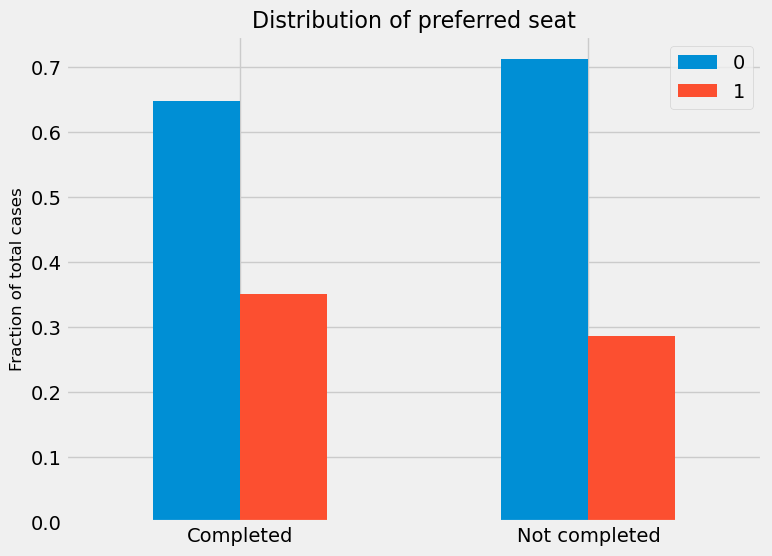

In [43]:
dfp, feature_labels = compareCategoricalFeatures(df_completed, df_not_completed, 'wants_preferred_seat', target_labels)

ax = dfp.plot(x="Outcome", y=feature_labels, kind="bar") 

plt.ylabel('Fraction of total cases', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of preferred seat', fontsize=16)
plt.xlabel('');

    There seems to be a small difference when requestng a preferred seat between completed and non-completed bookings.

<font size="4">**IN-FLIGHT MEALS**:</font>

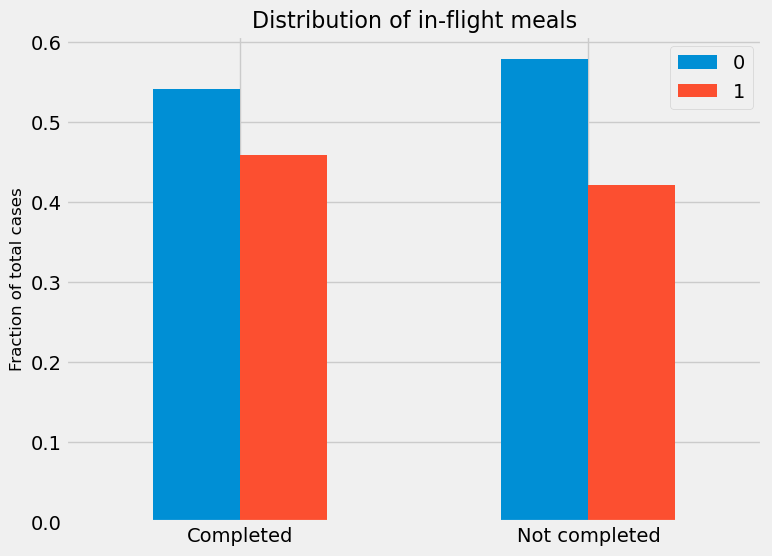

In [44]:
dfp, feature_labels = compareCategoricalFeatures(df_completed, df_not_completed, 'wants_in_flight_meals', target_labels)

ax = dfp.plot(x="Outcome", y=feature_labels, kind="bar") 

plt.ylabel('Fraction of total cases', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of in-flight meals', fontsize=16)
plt.xlabel('');

There seems to be a small difference when choosing in-flight meals between completed and non-completed bookings.

<font size="4">**FLIGHT DURATION**:</font>

[Text(1, 0, 'Completed'), Text(2, 0, 'Not completed')]

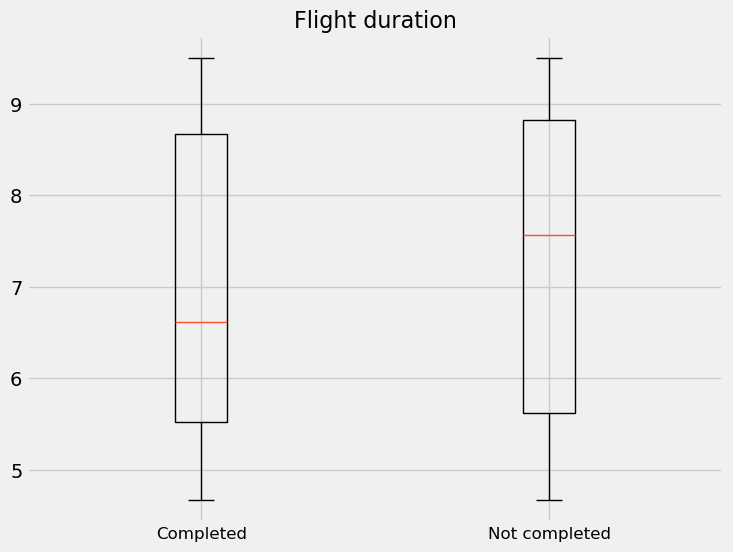

In [45]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([df_completed['flight_duration'], df_not_completed['flight_duration']], 0, 'gD')

plt.title('Flight duration', fontsize=16)

labels = ['Completed', 'Not completed']
ax.set_xticklabels(labels, fontsize=12)

Text(0.5, 1.0, 'Flight duration')

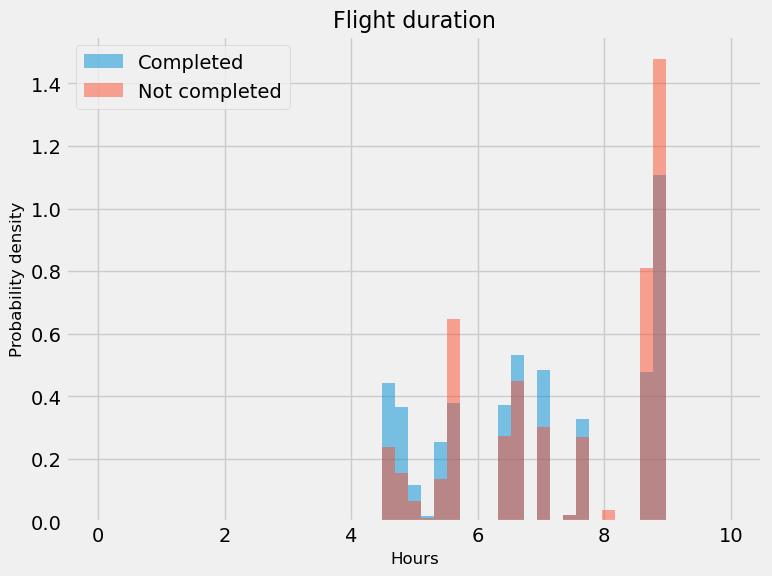

In [46]:
bins = np.linspace(0, 10, 50)

plt.hist(df_completed['flight_duration'], bins, alpha=0.5, density=True, label='Completed')
plt.hist(df_not_completed['flight_duration'], bins, alpha=0.5, density=True, label='Not completed')
plt.legend(loc='upper left')
plt.ylabel('Probability density', fontsize=12)
plt.xlabel('Hours', fontsize=12)
plt.title('Flight duration', fontsize=16)

The length of the flight seems to make a small difference when it comes to completed/non-completed bookings.

### 3.3.2.- Categorical features

In [47]:
categorical_columns

['sales_channel', 'trip_type', 'route', 'booking_origin']

<font size="4">**SALES CHANNEL**:</font>

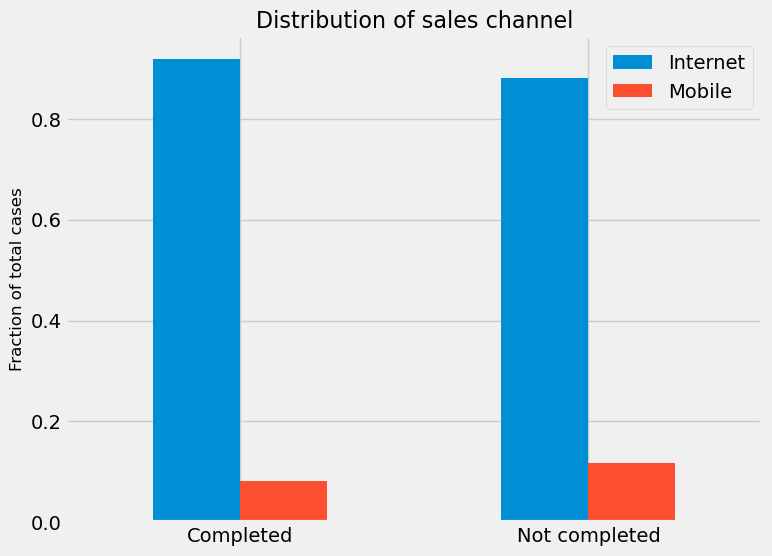

In [48]:
dfp, feature_labels = compareCategoricalFeatures(df_completed, df_not_completed, 'sales_channel', target_labels)

ax = dfp.plot(x="Outcome", y=feature_labels, kind="bar") 

plt.ylabel('Fraction of total cases', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of sales channel', fontsize=16)
plt.xlabel('');

The sales channel used for the booking makes very little difference in booking completion.

<font size="4">**TRIP TYPE**:</font>

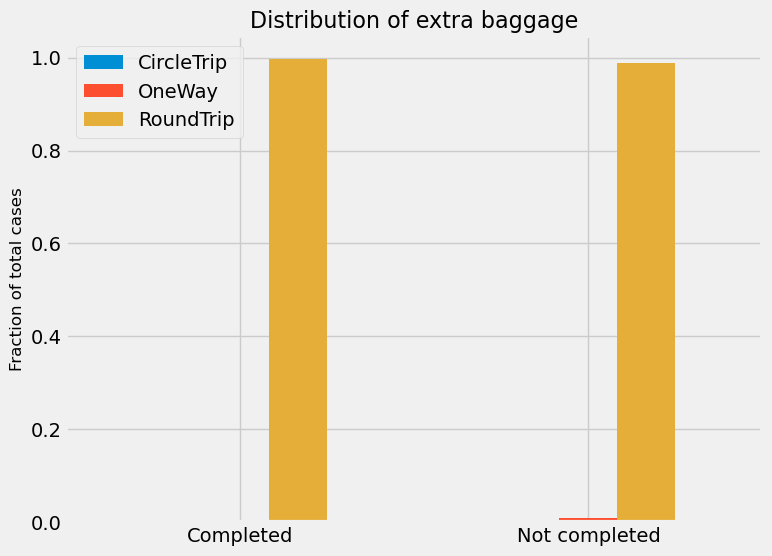

In [49]:
dfp, feature_labels = compareCategoricalFeatures(df_completed, df_not_completed, 'trip_type', target_labels)

ax = dfp.plot(x="Outcome", y=feature_labels, kind="bar") 

plt.ylabel('Fraction of total cases', fontsize=12)
ax.set_xticklabels(labels, rotation='horizontal') 
plt.title('Distribution of extra baggage', fontsize=16)
plt.xlabel('');

Trip type does not make a difference in the outcome of a booking.

<font size="4">**ROUTE**:</font>

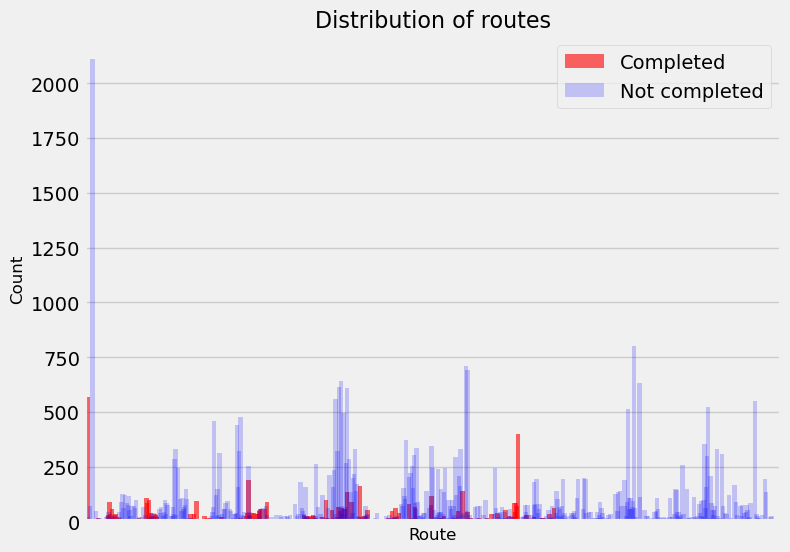

In [50]:
ax = df_completed['route'].value_counts().sort_index().plot.bar(alpha=0.6, label='Completed', color='red', width=5)
ax = df_not_completed['route'].value_counts().sort_index().plot.bar(alpha=0.2, label='Not completed', color='blue', 
                                                                    width=5)
plt.xlabel('Route', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of routes', fontsize=16)
plt.legend()
ax.set_xticks([]);

We see that there are routs clearly associated with a high proportion of completed bookings, whilst there are also routes with an unusually high proportion of bookings that are not completed.

<font size="4">**BOOKING ORIGIN**:</font>

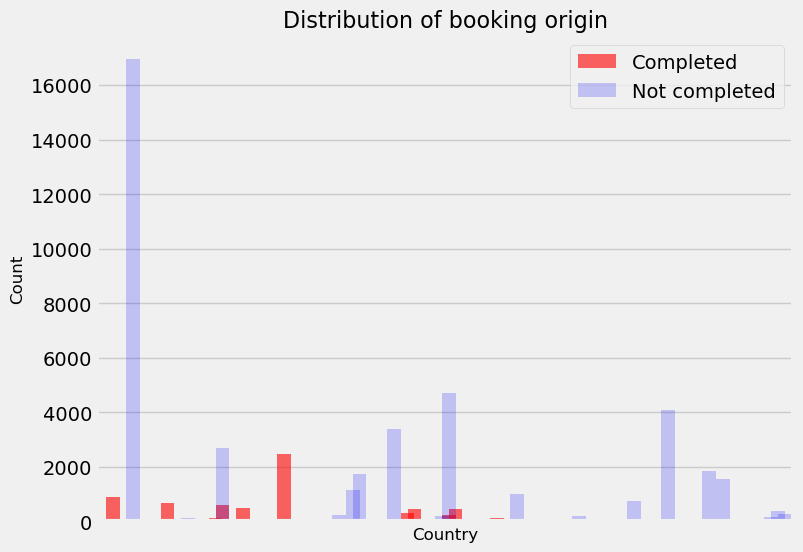

In [51]:
ax = df_completed['booking_origin'].value_counts().sort_index().plot.bar(alpha=0.6, label='Completed', 
                                                                         color='red', width=2)
ax = df_not_completed['booking_origin'].value_counts().sort_index().plot.bar(alpha=0.2, label='Not completed', 
                                                                             color='blue', width=2)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of booking origin', fontsize=16)
plt.legend()
ax.set_xticks([]);

There are some countries where there is a noticeable proportion of completed bookings; conversely, there are countries where there is a high proportion of non-completed bookings. There is clear predictive power associated to this feature.